In [1]:
import cv2
import sys
import pytesseract
import numpy as np
import matplotlib.pyplot as plt
import math 
from __future__ import print_function
import pyzbar.pyzbar as pyzbar
%matplotlib inline

cv2.__version__

'4.0.0'

In [2]:
# Display barcode and QR code location
def split_image(im, n_rows=2, n_images_per_row=2):
    height, width,_ = im.shape
    roi_height = round(height / n_rows)
    roi_width = round(width / n_images_per_row)

    images = []

    for x in range(0, n_rows):
        for y in range(0, n_images_per_row):
            tmp_image=im[x*roi_height:(x+1)*roi_height, y*roi_width:(y+1)*roi_width]
            images.append(tmp_image)
            
    return images


def process_image_for_ocr(im):
    # TODO : Implement using opencv
    im_new = remove_noise_and_smooth(im)
    return im_new


def image_smoothening(img, BINARY_THREHOLD = 180):
    ret1, th1 = cv2.threshold(img, BINARY_THREHOLD, 255, cv2.THRESH_BINARY)
    ret2, th2 = cv2.threshold(th1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    blur = cv2.GaussianBlur(th2, (1, 1), 0)
    ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return th3


def remove_noise_and_smooth(img):
    filtered = cv2.adaptiveThreshold(img.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 41, 3)
    kernel = np.ones((1, 1), np.uint8)
    opening = cv2.morphologyEx(filtered, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    img = image_smoothening(img)
    or_image = cv2.bitwise_or(img, closing)
    return or_image

In [90]:
def process_text_list(text_list, part_length=5):
    i = 0
    ret = []
    length = len(text_list)
    while i < length and len(text_list[i]) < part_length:
        i = i + 1
    if i >= length:
        return " ".join(text_list)
    ret.append(text_list[i][len(text_list[i])-part_length:])   
    i = i + 1
    while i < length and len(text_list[i]) < part_length:
        i = i + 1
    if i >= length:
        return " ".join(text_list)
    ret.append(text_list[i][len(text_list[i])-part_length:])
    j = length - 1
    while j > i and len(text_list[j]) < part_length:
        j = j - 1
    ret.append(text_list[j][:part_length])
    return " ".join(ret)

def clahe(img, clip_limit=2.0, grid_size=(8,8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
    return clahe.apply(img)

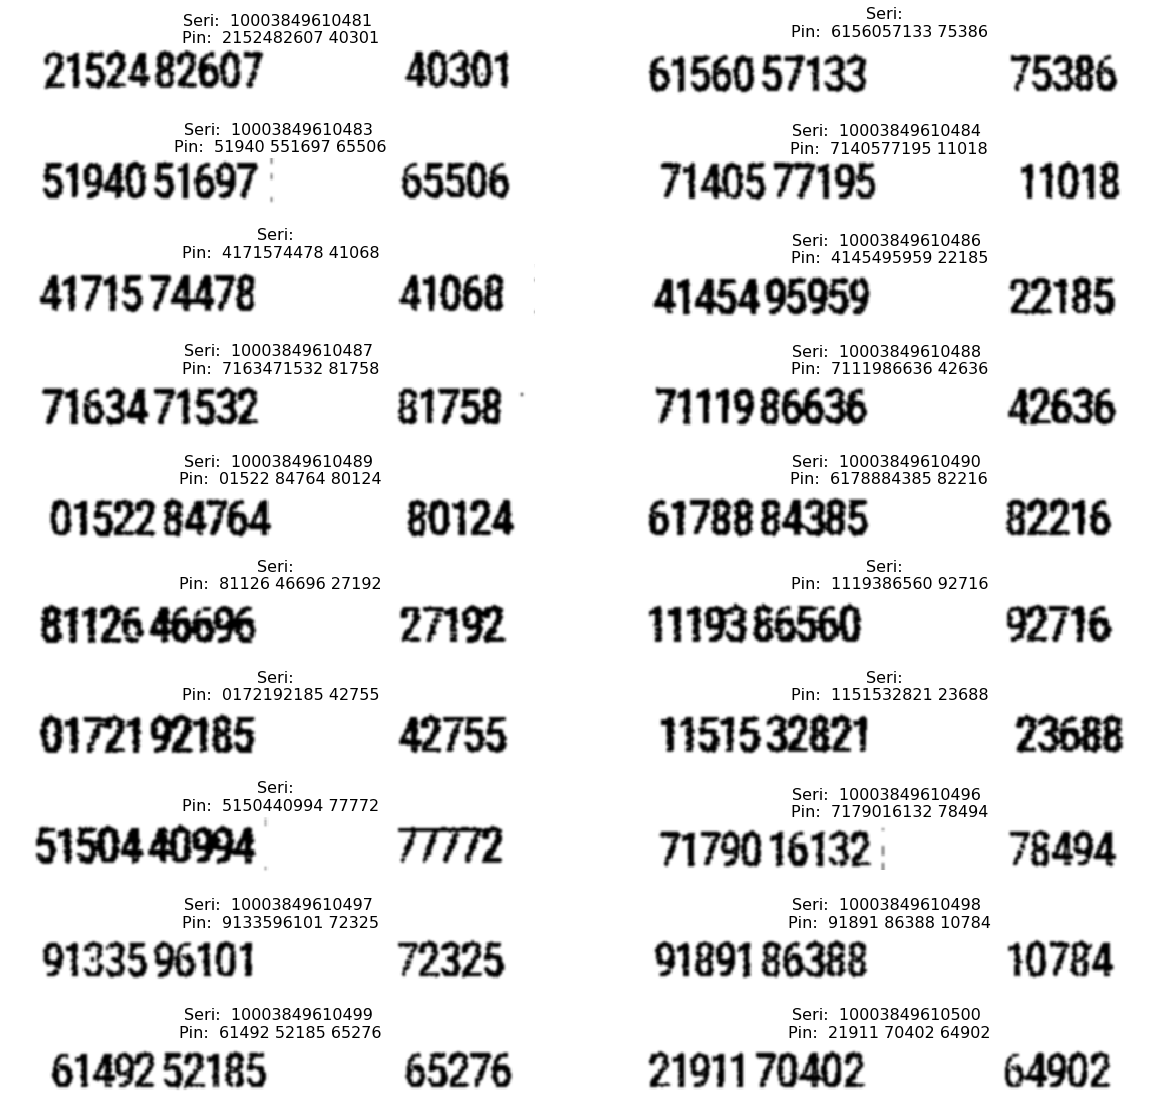

In [128]:
imPathRoot = "/Users/thanhtu/MyProjects/OCR-SIM"
imSplit = {
    "VT20": (2,2), 
    "VT50_L1": (4, 5),
}
qrDelete = {
    "VT20": (0.5, 0.72), 
    "VT50_L1": (0.5, 0.72),
}
imScale = {
    "VT20": (0.07, 0.95, 0.25, 0.5), 
    "VT50_L1": (0.1, 0.95, 0.27, 0.43),
}
imPaths = [
#     {"kind" : "VT20", "path": "image0000101A.jpg"},
    {"kind" : "VT50_L1", "path": "hoan0000002A.jpg"},
#     {"kind" : "VT20", "path": "image0000102A.jpg"},
#     {"kind" : "VT20", "path": "image0000103A.jpg"},
#     {"kind" : "VT20", "path": "image0000104A.jpg"},
#     {"kind" : "VT20", "path": "image0000105A.jpg"},
#     {"kind" : "VT20", "path": "image0000106A.jpg"},
#     {"kind" : "VT20", "path": "image0000107A.jpg"},
#     {"kind" : "VT20", "path": "image0000108A.jpg"},
#     {"kind" : "VT20", "path": "image0000109A.jpg"},
#     {"kind" : "VT20", "path": "image0000110A.jpg"},
]
# imPath = "images/cmt.jpg"
    
# Uncomment the line below to provide path to tesseract manually
# pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

# Define config parameters.
# '-l eng'  for using the English language
# '--oem 1' sets the OCR Engine Mode to LSTM only.
#
#  There are four OCR Engine Mode (oem) available
#  0    Legacy engine only.
#  1    Neural nets LSTM engine only.
#  2    Legacy + LSTM engines.
#  3    Default, based on what is available.
#
#  '--psm 3' sets the Page Segmentation Mode (psm) to auto.
#  Other important psm modes will be discussed in a future post.  

# psm = 8 so it will try to remove exceptional digit
config = ('-l digits --oem 1 --psm 7 -c jpg_quality=100')
im_list = []
orig_im_list = []
im_kind_list = []
# Read image from disk
for _, imPath in enumerate(imPaths):
    im_kind = imPath["kind"]
    im_full_path = imPathRoot + "/" + im_kind + "/" + imPath["path"]
    whole_im = cv2.imread(im_full_path)
    
    rows, cols = imSplit[im_kind]
    split_im_list = split_image(whole_im, rows, cols)
    for im in split_im_list:
        orig_im_list.append(im)
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        im_list.append(gray)
        im_kind_list.append(im_kind)

columns = 2
rows = math.ceil(len(im_list) / columns)
_, ax_tables = plt.subplots(rows, columns, figsize=[20,20])
    
for index, im in enumerate(im_list):
#     if not index in [4] :
#         continue
    # Find barcodes and QR codes
    
    #process noise for threshold    
    im = cv2.fastNlMeansDenoising(im,None,3,7,21)
    
    # dilate for qr scan
    kernel = np.ones((2, 2), np.uint8)
    im = cv2.dilate(im, kernel, iterations=1)    
    im = cv2.erode(im, kernel, iterations=1)
    
    # qr scan
    decodedObjects = pyzbar.decode(im, symbols=[pyzbar.ZBarSymbol.QRCODE])        

    text_list = ["Seri: "]
    # Print results
    qr_found = False
    for obj in decodedObjects:
        text_list.append(str(obj.data)[6:20])
        qr_found = True
        im = im[obj.rect.top + round(obj.rect.height/7):obj.rect.top + round(obj.rect.height/1.8), 0:im.shape[1]]
        cv2.rectangle(im, (obj.rect.left, 0), \
                      (obj.rect.left + obj.rect.width,  im.shape[0]), \
                      (255, 255, 255), cv2.FILLED)
        
    text_list.append("\nPin: ")
    
    if not qr_found:
        height, width = im.shape
        dx1, dx2 = qrDelete[im_kind]
        cv2.rectangle(im, (round(width * dx1), 0), (round(width * dx2), height), (255, 255, 255), cv2.FILLED)                    
        im = im[round(height*sy1):round(height*sy2), 0:width]             
    
    # Otsu's thresholding, help qrcode
    ret3, im = cv2.threshold(im, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Gaussian Blur, help detection    
    im = cv2.GaussianBlur(im, (5, 5), 0)   
    cv2.resize(im, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_CUBIC)
    
    height, width = im.shape    
    im_kind = im_kind_list[index]
    sx1, sx2, sy1, sy2 = imScale[im_kind]
    im = im[0:height, round(width*sx1):round(width*sx2)]
    
#     im = process_image_for_ocr(im)
    # Run tesseract OCR on image
#     print(pytesseract.image_to_string(im, config=config))
    d = pytesseract.image_to_data(im, config=config, output_type=pytesseract.Output.DICT)
#     print(im.shape)
#     print(d)
    
    n_boxes = len(d['level'])
    for i in range(n_boxes):
#         conf = int(d['conf'][i])
        text = d['text'][i].strip()
        if len(text) < 2:
            continue             
        text_list.append(text)
#         (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])                   
#         cv2.rectangle(im, (x, y), (x + w, y + h), (255, 0, 0), 2)
    
    row = math.floor(index / columns)
    column = index % columns
    if rows > 1:
        ax = ax_tables[row][column]
    else:
        ax = ax_tables[column]
    ax.axis('off')
#     text = process_text_list(text_list)
    text = " ".join(text_list)
    ax.set_title(text, fontsize=16)
    ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    
